
# Knight on Chess Board

* [Steps by Knight](https://practice.geeksforgeeks.org/problems/steps-by-knight5927/1/)

Wnen a Knight can take L shape move in which the distances it moves in x and y directions are represented as ```[dx,dy]```, as long as he is on the board, we denote the knight as ```knight[1,3]```. ```[dx,dy]``` can be any of ```[1,3],[1,-3],[-1,3],[-1,-3]```.


To move from ```(3,4)``` to ```(0,0)```, the ```knight[1,3]``` takes minimum 3 steps ```(3,4) -> (4,2) -> (2,1) -> (0,0).```

<img src="../image/KnightChess.jpg" align="left" width=300/>

# Destinations where the knight can go as a Graph

The locations where the ```knight[d0,d1]``` can go from ```(x,y)``` can be represented as a graph whose nodes are the coordiantes of the locations.

From the node ```(x,y)```, take one move from ```[1,3],[1,-3],[-1,3],[-1,-3]``` to get to the next node. Try all the moves until all the location the knight can go are exhausted.

## NetworkX
Use NetworkX to build the graph.

* [NetworkX - Software for Complex Networks](https://networkx.org/documentation/stable/index.html)

> NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
> * tools for the study of the structure and dynamics of social, biological, and infrastructure networks;
> * a standard programming interface and graph implementation that is suitable for many applications;
> * a rapid development environment for collaborative, multidisciplinary projects;
> * an interface to existing numerical algorithms and code written in C, C++, and FORTRAN; and
> * the ability to painlessly work with large nonstandard data sets.

* [NetworkX - Tutorial](https://networkx.org/documentation/stable/tutorial.html)



# Setup

In [1]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('LOGGER_NAME')

In [2]:
import threading
from itertools import (
    combinations,
    combinations_with_replacement,
    permutations,
    product,
)
import operator
import networkx as nx
import matplotlib.pyplot as plt

# Constant

In [3]:
N = 5  # Board size
ORIGINATION = (0,0)
DESTINATION = (4,4)

# All the moves the knight can make

In [4]:
(dx, dy) = (1, 3)

# All possible signs
signs = list(product([1, -1], repeat=2))

# All possible combination of [(+/-, +/-), (dx, dy)]
combinations = product(signs, [(dx, dy), (dy, dx)])

# All possible moves (x,y)
movements = [
    tuple(map(operator.mul, sign, xy))
    for (sign, xy) in combinations
]
movements

[(1, 3), (3, 1), (1, -3), (3, -1), (-1, 3), (-3, 1), (-1, -3), (-3, -1)]

In [5]:
def create_possible_movements(dx, dy):
    """Generate all possible (dx, dy) and (dy, dx) combinations without duplicates.
    (dx, dy)
    (dy, dx)
    (dx, -dy)
    (dy, -dx)
    (-dx, dy)
    (-dy, dx)
    (-dx, -dy)
    (-dy, -dx)
    
    For (dx, dy)=(2,2),
    (2,2)
    (2,-2)
    (-2,2)
    (-2,-2)
    """
    # All possible signs
    signs = list(product([1, -1], repeat=2))

    # All possible combination of [(+/-, +/-), (dx, dy)]
    combinations = product(signs, [(dx, dy), (dy, dx)])

    # All possible moves (dx,dy) and (dy, dx)
    movements = set([
        tuple(map(operator.mul, sign, dxdy))
        for (sign, dxdy) in combinations
    ])
    return movements

In [6]:
print(create_possible_movements(1,3))
print(create_possible_movements(2,2))

{(-3, -1), (3, -1), (-3, 1), (3, 1), (-1, -3), (1, -3), (-1, 3), (1, 3)}
{(2, -2), (-2, 2), (-2, -2), (2, 2)}


# Chess Board

In [7]:
size = N
ticks = list(range(0, N, 1))
ticks

[0, 1, 2, 3, 4]

In [8]:
coordinates = list(product(ticks, repeat=2))
for (x, y) in coordinates:
    print(f"(x,y)={x,y}")
    
print(f"\nTotal {len(coordinates)}")

(x,y)=(0, 0)
(x,y)=(0, 1)
(x,y)=(0, 2)
(x,y)=(0, 3)
(x,y)=(0, 4)
(x,y)=(1, 0)
(x,y)=(1, 1)
(x,y)=(1, 2)
(x,y)=(1, 3)
(x,y)=(1, 4)
(x,y)=(2, 0)
(x,y)=(2, 1)
(x,y)=(2, 2)
(x,y)=(2, 3)
(x,y)=(2, 4)
(x,y)=(3, 0)
(x,y)=(3, 1)
(x,y)=(3, 2)
(x,y)=(3, 3)
(x,y)=(3, 4)
(x,y)=(4, 0)
(x,y)=(4, 1)
(x,y)=(4, 2)
(x,y)=(4, 3)
(x,y)=(4, 4)

Total 25


In [9]:
def move(n, position, movement):
    """
    Args:
        n: size
        position: coordinate as (x,y)
        movement: distance to move as (dx, dy)
    Returns:
        new position (x, y) if it is within (0 <= x|y < n-1), othewise None
    """
    x = position[0]
    y = position[1]
    dx = movement[0]
    dy = movement[1]
    new_x = x + dx
    new_y = y + dy
    if (0 <= new_x < n) and (0 <= new_y < n):
        return (new_x, new_y)
    else: 
        # logger.debug("move(): cannot go to %s." % ((new_x, new_y),))
        return None


position = (1,3)
for movement in movements:
    destination = move(5, position, movement)
    if destination:
        print(f"Can go to {destination}")

Can go to (4, 4)
Can go to (2, 0)
Can go to (4, 2)
Can go to (0, 0)



### Check if the graph has (current -> destination) path

* [DiGraph.has_edge(u, v)](https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.has_edge.html#networkx.DiGraph.has_edge)



In [10]:
Lock = threading.Lock()


def check_path_and_update_graph(current, destination, graph):
    """
    A node in the graph can be arrived via different routes. If the destination is not yet 
    visited via the (current->destination) path, add the destination and the directed path
    to the graph.
            
    Args:
        current: current position
        destination: destination coordinate
        graph: graph of destinations
        
    Returns:
        True if new destination, otherwise False
    """
    visit_further = False
    with Lock:
        # --------------------------------------------------------------------------------
        # Check if graph alreadyhas has (current -> destination) path with DiGraph.has_edge().
        # https://networkx.org/documentation/stable/reference/classes/digraph.html
        # --------------------------------------------------------------------------------
        if not graph.has_edge(current, destination):
            logger.debug(
                "check_path_and_update_graph(): %s is not yet visited from %s. Adding to the graph..." 
                % (destination, current)
            )
            graph.add_node(destination)
            graph.add_edge(current, destination)

            logger.debug("check_path_and_update_graph(): updated graph: [%s]" % list(graph.nodes()))
            return True
        else:
            return False

In [11]:
def visit(n, position, movements, graph):
    """Visit all the locations reachable from the position and add the locations and directed
    paths to there in the graph.
    
    Args:
        n: size of the board
        position: current position
        movement: avialable move to the next destinations
        graph: graph object to update
    Returns:
        number of new destinations found reachable from the position
    """
    new_destinations_found = 0
    
    logger.debug("visit(): position: %s movements: %s" % (position, movements))
    for movement in movements:
        destination = move(n, position, movement)
        if destination is not None:
            # --------------------------------------------------------------------------------
            # If the destination is not yet visited from the , add it to the graph and explore further
            # from the destination
            # --------------------------------------------------------------------------------
            if check_path_and_update_graph(position, destination, graph):
                logger.debug("Moving to the destination %s." % (destination,))
                new_destinations_found += 1
                new_destinations_found += visit(n, destination, movements, graph)

    return new_destinations_found

## Build a directed graph

* [DiGraph—Directed graphs with self loops](https://networkx.org/documentation/stable/reference/classes/digraph.html)


In [12]:
origination = ORIGINATION

graph = nx.DiGraph()
graph.add_node(origination)

In [13]:
(dx, dy) = (1,3)
movements = create_possible_movements(dx, dy)
visit(n=N, position=origination, movements=movements, graph=graph)

32

# Visualize the Graph

* [Networkx - Drawing](https://networkx.org/documentation/stable/reference/drawing.html)

> NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package.
> 
> Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are Cytoscape, Gephi, Graphviz and, for LaTeX typesetting, PGF/TikZ. To use these and other such tools, you should export your NetworkX graph into a format that can be read by those tools. For example, Cytoscape can read the GraphML format, and so, networkx.write_graphml(G, path) might be an appropriate choice.

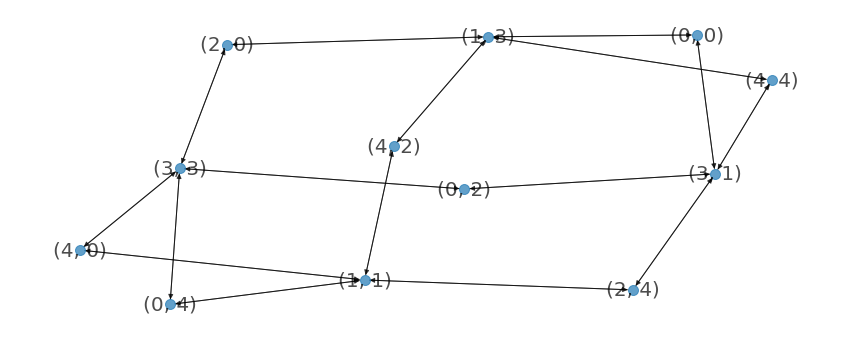

In [14]:
figure, ax = plt.subplots(figsize=(15,6))
nx.draw_kamada_kawai(graph, node_size=100, alpha=0.7, arrows=True, with_labels=True, font_size=20)

# Shortest Path 

* [NetworkX - Shortest Path](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html)

In [15]:
def get_shortest_paths(graph, origination, destination):
    """Get the shortest paths from origination to destination
    """
    try:
        return list(nx.all_shortest_paths(graph, origination, destination))
    except nx.NetworkXNoPath:
        return None

In [16]:
get_shortest_paths(graph=graph, origination=ORIGINATION, destination=DESTINATION)

[[(0, 0), (3, 1), (4, 4)], [(0, 0), (1, 3), (4, 4)]]

---

# [KnightL on a Chessboard](https://www.hackerrank.com/contests/rookierank-2/challenges/knightl-on-chessboard/problem)

In [17]:
def get_shortest_route_sizes(n):
    """
    For all the possible move=(dx, dy) where move is the movement an object can make 
    in x and y directions, find the size of the shortest route from the origination 
    (0,0) to the destination (n-1,n-1) for each (dx, dy).
    
    If there is no such route, then the size is -1.
    
    Create a 2D matrix where each row corresponds with dx where dx: 0 <= dx < n and
    each column corresponds with dy where dy: 0 <= dy < n.
    
    Args:
        n: Board size
    Returns:
        2D matrix of the shortest route size    
    """
    origination = (0,0)
    destination = (n-1, n-1)

    result = []
    for dx in range(1, n):
        shortests = []
        for dy in range(1, n):
            graph = nx.DiGraph()
            graph.add_node(origination)
            movements = create_possible_movements(dx, dy)
            
            visit(n=n, position=origination, movements=movements, graph=graph)
            paths = get_shortest_paths(graph=graph, origination=origination, destination=destination)
            if paths:
                shortests.append(len(paths[0]) -1)
            else:
                shortests.append(-1)
        result.append(shortests)
        
    return result

In [18]:
get_shortest_route_sizes(n=10)

[[9, 6, 5, 8, 5, 6, 7, 2, 9],
 [6, -1, 6, -1, 10, -1, 2, -1, -1],
 [5, 6, 3, 6, 7, 2, 13, -1, 3],
 [8, -1, 6, -1, 2, -1, -1, -1, -1],
 [5, 10, 7, 2, -1, -1, -1, -1, -1],
 [6, -1, 2, -1, -1, -1, -1, -1, -1],
 [7, 2, 13, -1, -1, -1, -1, -1, -1],
 [2, -1, -1, -1, -1, -1, -1, -1, -1],
 [9, -1, 3, -1, -1, -1, -1, -1, 1]]